<a href="https://colab.research.google.com/github/mrkkrueger/final_project/blob/main/final_project_recidivism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing the dataset

In [161]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [163]:
# Connect to data set - other users may need to change this code to access dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/final_project/NIJ_s_Recidivism_Challenge_Full_Dataset_20240318.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


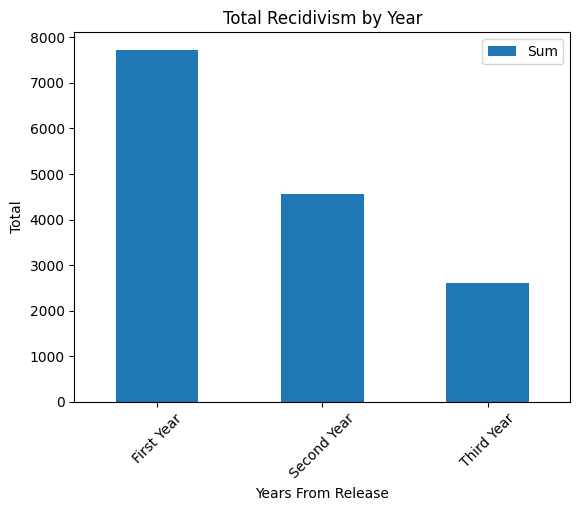

In [164]:
# Create bar charts to visualize total recidivism

sum_recid1=df['Recidivism_Arrest_Year1'].sum()
sum_recid2=df['Recidivism_Arrest_Year2'].sum()
sum_recid3=df['Recidivism_Arrest_Year3'].sum()
no_arrest=len(df)-sum_recid_within3


sum_df=pd.DataFrame({'Sum':[sum_recid1,sum_recid2,sum_recid3]},index=['First Year','Second Year', 'Third Year'])
sum_df.plot(kind='bar')
plt.title('Total Recidivism by Year')
plt.xlabel('Years From Release')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.show()


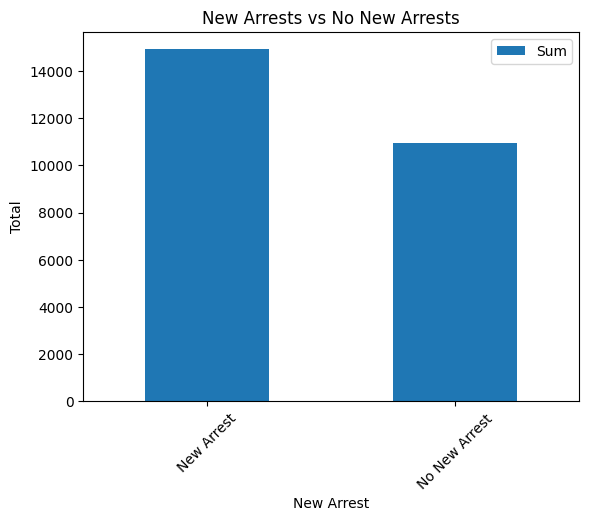

In [165]:
# Bar chart showing recidivate vs not
sum_recid_within3=df['Recidivism_Within_3years'].sum()
no_arrest=len(df)-sum_recid_within3

sum_df=pd.DataFrame({'Sum':[sum_recid_within3,no_arrest]},index=['New Arrest','No New Arrest'])
sum_df.plot(kind='bar')
plt.title('New Arrests vs No New Arrests')
plt.xlabel('New Arrest')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.show()


In [166]:
# drop columns"ID" and "Training_Sample" (wll create own training data)
df=df.drop(["ID","Training_Sample"],1)

# verify dropped columns
print(df.columns)


Index(['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Con

<ipython-input-166-44f753b8ad81>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop(["ID","Training_Sample"],1)


In [167]:
# Determine number of unique values in each column
df.nunique()

Gender                                                   2
Race                                                     2
Age_at_Release                                           7
Residence_PUMA                                          25
Gang_Affiliated                                          2
Supervision_Risk_Score_First                            10
Supervision_Level_First                                  3
Education_Level                                          3
Dependents                                               4
Prison_Offense                                           5
Prison_Years                                             4
Prior_Arrest_Episodes_Felony                            11
Prior_Arrest_Episodes_Misd                               7
Prior_Arrest_Episodes_Violent                            4
Prior_Arrest_Episodes_Property                           6
Prior_Arrest_Episodes_Drug                               6
Prior_Arrest_Episodes_PPViolationCharges                

In [168]:
# Several columns have lots of digits after the decimal place.
# Round columns that are precents to the nereast tenth digit, also serves as a way to bin the data
df[['DrugTests_THC_Positive',
    'DrugTests_Cocaine_Positive',
    'DrugTests_Meth_Positive',
    'DrugTests_Other_Positive',
    'Percent_Days_Employed',]]=df[[
    'DrugTests_THC_Positive',
    'DrugTests_Cocaine_Positive',
    'DrugTests_Meth_Positive',
    'DrugTests_Other_Positive',
    'Percent_Days_Employed'
    ]].round(1)

# Round column Avg_Days_per_DrugTest to the nearest whole number - this will make make it so it shows whole days, not fraction of days. Same with Jobs_Per_Year - you can't have half a job.
df[['Avg_Days_per_DrugTest','Jobs_Per_Year']]=df[['Avg_Days_per_DrugTest','Jobs_Per_Year']].round()

# Recheck unique values
df.nunique()

Gender                                                 2
Race                                                   2
Age_at_Release                                         7
Residence_PUMA                                        25
Gang_Affiliated                                        2
Supervision_Risk_Score_First                          10
Supervision_Level_First                                3
Education_Level                                        3
Dependents                                             4
Prison_Offense                                         5
Prison_Years                                           4
Prior_Arrest_Episodes_Felony                          11
Prior_Arrest_Episodes_Misd                             7
Prior_Arrest_Episodes_Violent                          4
Prior_Arrest_Episodes_Property                         6
Prior_Arrest_Episodes_Drug                             6
Prior_Arrest_Episodes_PPViolationCharges               6
Prior_Arrest_Episodes_DVCharges

In [169]:
# Find the number of null values
df.isnull().sum()

Gender                                                  0
Race                                                    0
Age_at_Release                                          0
Residence_PUMA                                          0
Gang_Affiliated                                      3167
Supervision_Risk_Score_First                          475
Supervision_Level_First                              1720
Education_Level                                         0
Dependents                                              0
Prison_Offense                                       3277
Prison_Years                                            0
Prior_Arrest_Episodes_Felony                            0
Prior_Arrest_Episodes_Misd                              0
Prior_Arrest_Episodes_Violent                           0
Prior_Arrest_Episodes_Property                          0
Prior_Arrest_Episodes_Drug                              0
Prior_Arrest_Episodes_PPViolationCharges                0
Prior_Arrest_E

In [170]:
# Length of dataframe
len(df)

25835

In [171]:
# Remove nulls
df=df.dropna()

# Length of dataframe after dropping nulls
len(df)

14170

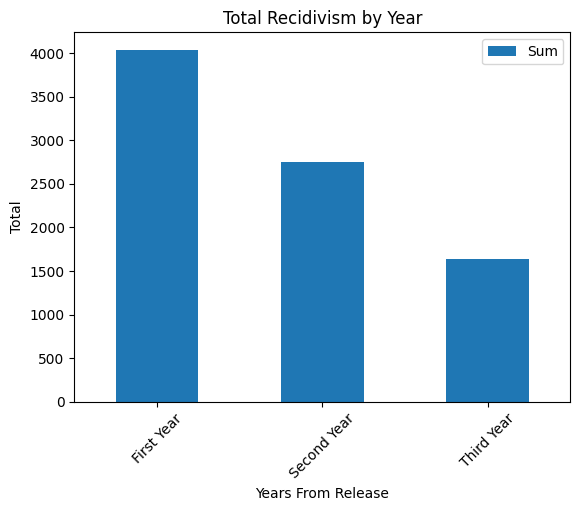

In [172]:
# Create bar charts to visualize total recidivism

sum_recid1=df['Recidivism_Arrest_Year1'].sum()
sum_recid2=df['Recidivism_Arrest_Year2'].sum()
sum_recid3=df['Recidivism_Arrest_Year3'].sum()
no_arrest=len(df)-sum_recid_within3


sum_df=pd.DataFrame({'Sum':[sum_recid1,sum_recid2,sum_recid3]},index=['First Year','Second Year', 'Third Year'])
sum_df.plot(kind='bar')
plt.title('Total Recidivism by Year')
plt.xlabel('Years From Release')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.show()

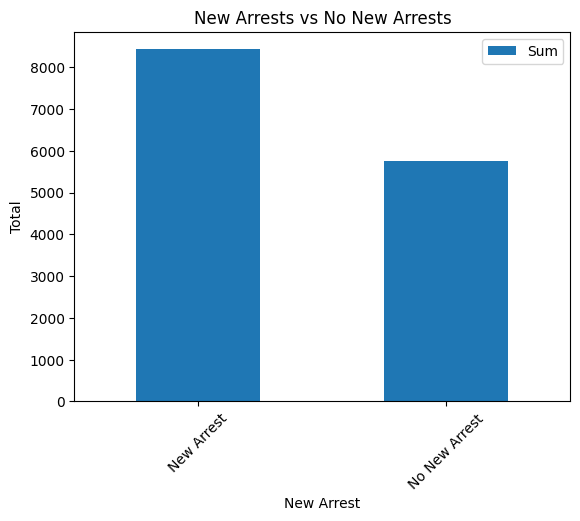

In [173]:
# Bar chart showing recidivate vs not
sum_recid_within3=df['Recidivism_Within_3years'].sum()
no_arrest=len(df)-sum_recid_within3

sum_df=pd.DataFrame({'Sum':[sum_recid_within3,no_arrest]},index=['New Arrest','No New Arrest'])
sum_df.plot(kind='bar')
plt.title('New Arrests vs No New Arrests')
plt.xlabel('New Arrest')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.show()

In [174]:
# Create dummy variables
df = pd.get_dummies(df, columns=["Gender",
                                     "Race",
                                     "Age_at_Release",
                                     "Supervision_Level_First",
                                     "Education_Level",
                                     "Dependents",
                                     "Prison_Offense",
                                     "Prison_Years",
                                     "Prior_Arrest_Episodes_Felony",
                                     "Prior_Arrest_Episodes_Misd",
                                     "Prior_Arrest_Episodes_Violent",
                                     "Prior_Arrest_Episodes_Property",
                                     "Prior_Arrest_Episodes_Drug",
                                     'Prior_Arrest_Episodes_PPViolationCharges',
                                     'Prior_Conviction_Episodes_Felony',
                                     'Prior_Conviction_Episodes_Misd',
                                     'Prior_Conviction_Episodes_Prop',
                                     'Prior_Conviction_Episodes_Drug',
                                     'Delinquency_Reports',
                                     'Program_Attendances',
                                     'Program_UnexcusedAbsences',
                                     'Residence_Changes'
                                     ])
df.head()

,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Viol,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,...,Program_Attendances_8,Program_Attendances_9,Program_UnexcusedAbsences_0,Program_UnexcusedAbsences_1,Program_UnexcusedAbsences_2,Program_UnexcusedAbsences_3 or more,Residence_Changes_0,Residence_Changes_1,Residence_Changes_2,Residence_Changes_3 or more
0,16,False,3.0,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,1,0
1,16,False,6.0,True,False,True,True,True,True,False,...,0,0,1,0,0,0,0,0,1,0
2,24,False,7.0,True,False,True,False,True,False,False,...,0,0,1,0,0,0,1,0,0,0
3,16,False,7.0,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,0,1
4,16,False,4.0,True,False,True,False,False,False,False,...,0,0,1,0,0,0,1,0,0,0


In [182]:
# Create new dataframes for recidivism time (1 year, 2 year, 3 year, or anytime in 3 years)
# For 1 year, 2 year, and 3 year, removing rows where they had a new arrest in a different year.

recid_1yr = df[(df['Recidivism_Arrest_Year2'] != True) & (df['Recidivism_Arrest_Year3'] != True)]
recid_1yr=recid_1yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year2","Recidivism_Arrest_Year3"],1)

recid_2yr = df[(df['Recidivism_Arrest_Year1'] != True) & (df['Recidivism_Arrest_Year3'] != True)]
recid_2yr=recid_2yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year1","Recidivism_Arrest_Year3"],1)

recid_3yr = df[(df['Recidivism_Arrest_Year1'] != True) & (df['Recidivism_Arrest_Year2'] != True)]
recid_3yr=recid_3yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year2","Recidivism_Arrest_Year1"],1)


recid_any=df.drop(["Recidivism_Arrest_Year1","Recidivism_Arrest_Year2","Recidivism_Arrest_Year3"],1)

<ipython-input-182-eed5d436a8dd>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  recid_1yr=recid_1yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year2","Recidivism_Arrest_Year3"],1)
<ipython-input-182-eed5d436a8dd>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  recid_2yr=recid_2yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year1","Recidivism_Arrest_Year3"],1)
<ipython-input-182-eed5d436a8dd>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  recid_3yr=recid_3yr.drop(["Recidivism_Within_3years","Recidivism_Arrest_Year2","Recidivism_Arrest_Year1"],1)
<ipython-input-182-eed5d436a8dd>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword

Before further cleaining, testing the model

In [183]:
# Split data into features and target

#New arrest within three years
y=recid_any["Recidivism_Within_3years"]
X=recid_any.drop(["Recidivism_Within_3years"], axis=1)

#New arrest in first year
y1=recid_1yr["Recidivism_Arrest_Year1"]
X1=recid_1yr.drop(["Recidivism_Arrest_Year1"], axis=1)

#New arrest in second year
y2=recid_2yr["Recidivism_Arrest_Year2"]
X2=recid_2yr.drop(["Recidivism_Arrest_Year2"], axis=1)

#New arrest in third year
y3=recid_3yr["Recidivism_Arrest_Year3"]
X3=recid_3yr.drop(["Recidivism_Arrest_Year3"], axis=1)


In [184]:
# Split data into training and testing dataset
X_train,X_test,y_train,y_test,=train_test_split(X,y,random_state=48)
X1_train,X1_test,y1_train,y1_test,=train_test_split(X1,y1,random_state=48)
X2_train,X2_test,y2_train,y2_test,=train_test_split(X2,y2,random_state=48)
X3_train,X3_test,y3_train,y3_test,=train_test_split(X3,y3,random_state=48)

In [185]:
# Scaling data
#Creating StandardScaler instance
scaler=StandardScaler()
scaler1=StandardScaler()
scaler2=StandardScaler()
scaler3=StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)
X1_scaler = scaler.fit(X_train)
X2_scaler = scaler.fit(X_train)
X3_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

X3_train_scaled = X3_scaler.transform(X3_train)
X3_test_scaled = X3_scaler.transform(X3_test)


Testing with Random Forest

In [186]:
# Choosing machine learning algorithm
model = RandomForestClassifier()
model1 = RandomForestClassifier()
model2 = RandomForestClassifier()
model3 = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train_scaled, y_train)
model1.fit(X1_train_scaled, y1_train)
model2.fit(X2_train_scaled, y2_train)
model3.fit(X3_train_scaled, y3_train)

# Evaluate the model's performance on the testing data
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

y1_pred = model.predict(X1_test_scaled)
accuracy1 = accuracy_score(y1_test, y1_pred)

y2_pred = model.predict(X2_test_scaled)
accuracy2 = accuracy_score(y2_test, y2_pred)

y3_pred = model.predict(X3_test_scaled)
accuracy3 = accuracy_score(y3_test, y3_pred)

In [187]:
print("Classification Report for new arrest within 3 years: ")
print(classification_report(y_test, y_pred))

print("Classification Report for new arrest in first year: ")
print(classification_report(y1_test, y1_pred))

print("Classification Report for new arrest in second year: ")
print(classification_report(y2_test, y2_pred))

print("Classification Report for new arrest in third year: ")
print(classification_report(y3_test, y3_pred))

Classification Report for new arrest within 3 years: 
              precision    recall  f1-score   support

       False       0.67      0.52      0.58      1403
        True       0.72      0.83      0.77      2140

    accuracy                           0.71      3543
   macro avg       0.70      0.67      0.68      3543
weighted avg       0.70      0.71      0.70      3543

Classification Report for new arrest in first year: 
              precision    recall  f1-score   support

       False       0.98      0.89      0.93      1425
        True       0.86      0.98      0.92      1021

    accuracy                           0.92      2446
   macro avg       0.92      0.93      0.92      2446
weighted avg       0.93      0.92      0.93      2446

Classification Report for new arrest in second year: 
              precision    recall  f1-score   support

       False       0.97      0.89      0.93      1437
        True       0.80      0.95      0.87       688

    accuracy         

Importance of each variable, place later

In [188]:
# Feature Importance total
importances=model.feature_importances_
importances_sorted = sorted(zip(importances, X.columns), reverse=True)
importances_sorted[:10]


[(0.07785759367564644, 'Percent_Days_Employed'),
 (0.048333721413226914, 'Avg_Days_per_DrugTest'),
 (0.04061500110295737, 'Supervision_Risk_Score_First'),
 (0.03693845855178266, 'Residence_PUMA'),
 (0.021514186656961524, 'Jobs_Per_Year'),
 (0.021004824935800696, 'Gang_Affiliated'),
 (0.020842539645365265, 'DrugTests_THC_Positive'),
 (0.011505922654327346, 'Prior_Arrest_Episodes_PPViolationCharges_0'),
 (0.010415165720527707, 'Prior_Arrest_Episodes_Property_0'),
 (0.009477881447325094, 'Condition_MH_SA')]

In [189]:
# Feature importance 1st year
importances1=model1.feature_importances_
importances1_sorted = sorted(zip(importances1, X1.columns), reverse=True)
importances1_sorted[:10]

[(0.12597503513301747, 'Percent_Days_Employed'),
 (0.05042524866226016, 'Avg_Days_per_DrugTest'),
 (0.03728326520835264, 'Supervision_Risk_Score_First'),
 (0.03245923667323002, 'Residence_PUMA'),
 (0.030538214551366193, 'Gang_Affiliated'),
 (0.02784409655825109, 'DrugTests_THC_Positive'),
 (0.018685444356120094, 'Jobs_Per_Year'),
 (0.011569407019355044, 'Delinquency_Reports_4 or more'),
 (0.010674408914173024, 'Prior_Arrest_Episodes_PPViolationCharges_0'),
 (0.010270698832649135, 'Prior_Arrest_Episodes_Property_0')]

In [190]:
# Feature importance 2nd year
importances2=model2.feature_importances_
importances2_sorted = sorted(zip(importances2, X2.columns), reverse=True)
importances2_sorted[:10]

[(0.049890586129566115, 'Percent_Days_Employed'),
 (0.04812630756337836, 'Avg_Days_per_DrugTest'),
 (0.0382429197793627, 'Residence_PUMA'),
 (0.03381489242443924, 'Supervision_Risk_Score_First'),
 (0.023525372063419998, 'Jobs_Per_Year'),
 (0.020773063728083605, 'DrugTests_THC_Positive'),
 (0.016718901122332035, 'Gang_Affiliated'),
 (0.011549995791156929, 'Prior_Arrest_Episodes_PPViolationCharges_0'),
 (0.009851481421544815, 'Condition_Cog_Ed'),
 (0.009443800512021152, 'Prior_Conviction_Episodes_Misd_0')]

In [191]:
# Feature importance 3rd year
importances3=model3.feature_importances_
importances3_sorted = sorted(zip(importances3, X3.columns), reverse=True)
importances3_sorted[:10]


[(0.048989633815329336, 'Avg_Days_per_DrugTest'),
 (0.041649563777696436, 'Residence_PUMA'),
 (0.0348148884771903, 'Supervision_Risk_Score_First'),
 (0.03174326475143924, 'Percent_Days_Employed'),
 (0.01847611810653261, 'Jobs_Per_Year'),
 (0.015433705170436539, 'DrugTests_THC_Positive'),
 (0.01086294501410228, 'Gang_Affiliated'),
 (0.010069666739702965, 'Condition_Cog_Ed'),
 (0.009701808135937216, 'Education_Level_High School Diploma'),
 (0.009582748334504641, 'Residence_Changes_0')]

Neural Network - Within 3 years

In [192]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input=len(X_train_scaled[0])
h_1=15
h_2=15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=h_1,input_dim=num_input,activation="relu")
)

# Second hidden layer
nn.add(
    tf.keras.layers.Dense(units=h_2,activation="relu")
)

# Output layer
nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 15)                2040      
                                                                 
 dense_25 (Dense)            (None, 15)                240       
                                                                 
 dense_26 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2296 (8.97 KB)
Trainable params: 2296 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [193]:
# Compile the model
nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [194]:
# Train the model
fit_model=nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
333/333 [==============================] - 1s 2ms/step - loss: 0.6318 - accuracy: 0.6432
Epoch 2/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5662 - accuracy: 0.7073
Epoch 3/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5438 - accuracy: 0.7245
Epoch 4/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7357
Epoch 5/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5209 - accuracy: 0.7414
Epoch 6/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5130 - accuracy: 0.7472
Epoch 7/100
333/333 [==============================] - 1s 2ms/step - loss: 0.5044 - accuracy: 0.7532
Epoch 8/100
333/333 [==============================] - 1s 3ms/step - loss: 0.4984 - accuracy: 0.7558
Epoch 9/100
333/333 [==============================] - 1s 3ms/step - loss: 0.4917 - accuracy: 0.7618
Epoch 10/100
333/333 [==============================] - 1s 3ms/step - loss: 0.4864 - accura

In [195]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

333/333 - 1s - loss: 0.3325 - accuracy: 0.8559 - 508ms/epoch - 2ms/step
Loss: 0.3324652910232544, Accuracy: 0.8559330105781555


Neural Network - 1st year

In [196]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input1=len(X1_train_scaled[0])
hl_1=15
hl_2=15
h1_3=15

nn1 = tf.keras.models.Sequential()

# First hidden layer
nn1.add(
    tf.keras.layers.Dense(units=hl_1,input_dim=num_input1,activation="relu")
)

# Second hidden layer
nn1.add(
    tf.keras.layers.Dense(units=hl_2,activation="relu")
)

# Output layer
nn1.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn1.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 15)                2040      
                                                                 
 dense_28 (Dense)            (None, 15)                240       
                                                                 
 dense_29 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2296 (8.97 KB)
Trainable params: 2296 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [197]:
# Compile the model
nn1.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [198]:
# Train the model
fit_model1=nn1.fit(X1_train_scaled,y1_train,epochs=100)


Epoch 1/100
230/230 [==============================] - 1s 2ms/step - loss: 0.6429 - accuracy: 0.6283
Epoch 2/100
230/230 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.7443
Epoch 3/100
230/230 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7763
Epoch 4/100
230/230 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.7950
Epoch 5/100
230/230 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.8065
Epoch 6/100
230/230 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8138
Epoch 7/100
230/230 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.8197
Epoch 8/100
230/230 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8255
Epoch 9/100
230/230 [==============================] - 0s 2ms/step - loss: 0.3843 - accuracy: 0.8317
Epoch 10/100
230/230 [==============================] - 0s 2ms/step - loss: 0.3745 - accura

In [199]:
#Evaluate the model using the test data
model_loss, model_accuracy = nn1.evaluate(X1_train_scaled,y1_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


230/230 - 0s - loss: 0.1466 - accuracy: 0.9456 - 399ms/epoch - 2ms/step
Loss: 0.1466182917356491, Accuracy: 0.9456180930137634


Neural Network - 2nd Year

In [200]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input2=len(X2_train_scaled[0])
h2_1=15
h2_2=15
h2_3=15

nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(
    tf.keras.layers.Dense(units=h2_1,input_dim=num_input2,activation="relu")
)

# Second hidden layer
nn2.add(
    tf.keras.layers.Dense(units=h2_2,activation="relu")
)

# Output layer
nn2.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 15)                2040      
                                                                 
 dense_31 (Dense)            (None, 15)                240       
                                                                 
 dense_32 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2296 (8.97 KB)
Trainable params: 2296 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [201]:
# Compile the model
nn2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [202]:
# Train the model
fit_model2=nn2.fit(X2_train_scaled,y2_train,epochs=100)


Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6343 - accuracy: 0.6415
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5749 - accuracy: 0.6925
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5519 - accuracy: 0.7132
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5352 - accuracy: 0.7262
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5212 - accuracy: 0.7371
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5087 - accuracy: 0.7427
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.7477
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.7543
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4777 - accuracy: 0.7655
Epoch 10/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4700 - accura

In [203]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X2_train_scaled,y2_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


200/200 - 0s - loss: 0.2154 - accuracy: 0.9183 - 418ms/epoch - 2ms/step
Loss: 0.21537384390830994, Accuracy: 0.918261706829071


Neural Network - 3rd Year

In [204]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input3=len(X3_train_scaled[0])
h3_1=15
h3_2=15
h3_3=15

nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(
    tf.keras.layers.Dense(units=h3_1,input_dim=num_input3,activation="relu")
)

# Second hidden layer
nn3.add(
    tf.keras.layers.Dense(units=h3_2,activation="relu")
)

# Output layer
nn3.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn3.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 15)                2040      
                                                                 
 dense_34 (Dense)            (None, 15)                240       
                                                                 
 dense_35 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2296 (8.97 KB)
Trainable params: 2296 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [205]:
# Compile the model
nn3.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [206]:
# Train the model
fit_model3=nn3.fit(X3_train_scaled,y3_train,epochs=100)


Epoch 1/100
173/173 [==============================] - 1s 3ms/step - loss: 0.5895 - accuracy: 0.7043
Epoch 2/100
173/173 [==============================] - 1s 3ms/step - loss: 0.5131 - accuracy: 0.7758
Epoch 3/100
173/173 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.7773
Epoch 4/100
173/173 [==============================] - 0s 3ms/step - loss: 0.4861 - accuracy: 0.7782
Epoch 5/100
173/173 [==============================] - 0s 3ms/step - loss: 0.4763 - accuracy: 0.7800
Epoch 6/100
173/173 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.7834
Epoch 7/100
173/173 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7863
Epoch 8/100
173/173 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.7917
Epoch 9/100
173/173 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7995
Epoch 10/100
173/173 [==============================] - 0s 2ms/step - loss: 0.4333 - accura

In [207]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn3.evaluate(X3_train_scaled,y3_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


173/173 - 0s - loss: 0.1442 - accuracy: 0.9561 - 319ms/epoch - 2ms/step
Loss: 0.14416027069091797, Accuracy: 0.9561054706573486
